In [1]:
import os
import sys
import copy
import random
import json


import numpy as np
import pandas as pd

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import cv2
import albumentations

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import timm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import f1_score

In [2]:
# Configure data paths
DATA_PATH_1 = '/home/user3/work/data/tiles_ulaanbaatar_x1024_full'
DATA_PATH_2 = '/home/user3/work/data/tiles_ulaanbaatar_x1024_zero'

In [3]:
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(4)

def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
force_cudnn_initialization()

[ Using Seed :  4  ]


In [4]:
image_file_postfix = '_im.tif'
polygon_file_postfix = '_pl.tif'


def split_count(count, fraction):
    fraction_count = int(count * fraction)
    num_set = [i for i in range(count)]
    random.shuffle(num_set)
    return num_set[:fraction_count], num_set[fraction_count:]


def get_folder_list(dataset_path):
    folder_list = [os.path.join(dataset_path, fn) for fn in os.listdir(dataset_path)
                   if os.path.isdir(os.path.join(dataset_path, fn))]
    folder_list = sorted(folder_list)
    return folder_list


def load_dataset(folder_list):
    folder_list = sorted(folder_list)
    result = []
    for folder in folder_list:
        file_list = [os.path.join(folder, fn) for fn in os.listdir(folder) if os.path.isfile(os.path.join(folder, fn))]
        
        # Get list of tiles
        unique_names = [fp for fp in file_list if fp.endswith(image_file_postfix)]
        unique_names = [os.path.basename(fp)[:-len(image_file_postfix)] for fp in unique_names]
        for name in unique_names:
            path_list = [
                os.path.join(folder, name + image_file_postfix),
                os.path.join(folder, name + polygon_file_postfix),
            ]
            if not all([os.path.exists(i) for i in path_list]):
                raise ValueError('Invalid path in list ' + str(path_list))
            result.append(path_list)
    return result

In [5]:
train_augumentations = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.50),
    albumentations.RandomRotate90(p=0.75),
    albumentations.Rotate(limit=45, p=1),
    albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
    albumentations.ShiftScaleRotate(),
    albumentations.RGBShift(),
    albumentations.OneOf([
        albumentations.Blur(),
        albumentations.GaussNoise(),
        albumentations.Sharpen (alpha=(0.05, 0.1), lightness=(0.1, 0.5), p=0.5),
    ], p=0.75),
    albumentations.Cutout(p=0.33),
    albumentations.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
    albumentations.RandomCrop(height=512, width=512, always_apply=True),
    ])

valid_augumetations = albumentations.Compose([
        albumentations.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albumentations.CenterCrop(height=512, width=512, always_apply=True),
    ])

/home/user3/work/code/tgeo/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [6]:
# Source 1
valid_set = [('3', '0_3_im.tif'),
 ('4', '1_2_im.tif'),
 ('21', '0_0_im.tif'),
 ('41', '0_1_im.tif'),
 ('36', '1_2_im.tif'),
 ('3', '0_0_im.tif'),
 ('29', '0_3_im.tif'),
 ('8', '1_2_im.tif'),
 ('41', '1_0_im.tif'),
 ('18', '3_1_im.tif'),
 ('6', '3_2_im.tif'),
 ('2', '3_3_im.tif'),
 ('36', '2_3_im.tif'),
 ('3', '2_0_im.tif'),
 ('3', '2_1_im.tif'),
 ('41', '0_0_im.tif'),
 ('41', '2_0_im.tif'),
 ('23', '1_0_im.tif'),
 ('41', '0_3_im.tif'),
 ('8', '0_1_im.tif'),
 ('6', '2_3_im.tif'),
 ('1', '3_0_im.tif'),
 ('5', '2_0_im.tif'),
 ('3', '1_1_im.tif'),
 ('1', '2_2_im.tif'),
 ('29', '0_0_im.tif'),
 ('19', '1_1_im.tif'),
 ('3', '1_2_im.tif'),
 ('3', '3_1_im.tif'),
 ('2', '3_0_im.tif'),
 ('6', '3_0_im.tif'),
 ('41', '0_2_im.tif'),
 ('6', '1_3_im.tif')]

folder_list = get_folder_list(DATA_PATH_1)

tiles = load_dataset(folder_list)

train_tiles = [i for i in tiles if (str.split(os.path.dirname(i[0]), '/')[-1], os.path.basename(i[0])) not in valid_set]
valid_tiles = [i for i in tiles if (str.split(os.path.dirname(i[0]), '/')[-1], os.path.basename(i[0])) in valid_set]

print(len(train_tiles))
print(len(valid_tiles))

# Source 2
valid_list = ['1375', '1728', '1624', '951', '1841', '456', '1855', '1577']
folder_list = get_folder_list(DATA_PATH_2)

train_tiles.extend(load_dataset([i for i in folder_list if os.path.basename(i) not in valid_list]))
valid_tiles.extend(load_dataset([i for i in folder_list if os.path.basename(i) in valid_list]))

print(len(train_tiles))
print(len(valid_tiles))

207
33
527
161


In [7]:
class ClassificationDataset(BaseDataset):
    
    def __init__(
        self, 
        dataset_tiles,
        augmentation=None, 
    ):
        super().__init__()
        self.dataset_tiles = dataset_tiles
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image_p, mask_p = self.dataset_tiles[i]
            
        image = cv2.imread(image_p, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_p).clip(0, 1)[:,:,0].astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image_t = torch.from_numpy(image)
        image_t = image_t.permute((2, 0, 1)).contiguous()
        
        class_num = 0 if np.all(mask == 0) else 1
            
        return image_t, torch.squeeze(torch.Tensor([class_num]).long())
        
    def __len__(self):
        return len(self.dataset_tiles)

In [8]:
train_dataset = ClassificationDataset(train_tiles, augmentation=train_augumentations)
print('train_dataset count', len(train_dataset))
valid_dataset = ClassificationDataset(valid_tiles, augmentation=valid_augumetations)
print('valid_dataset count', len(valid_dataset))

train_dataset count 527
valid_dataset count 161


tensor(0)


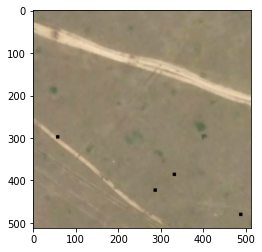

tensor(0)


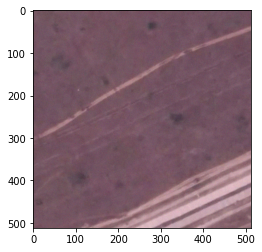

tensor(0)


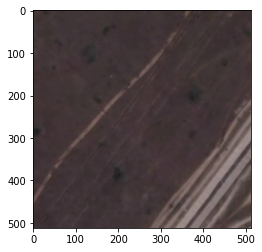

In [9]:
n = random.randint(0, len(train_dataset))
for i in range(3):
    im, l = train_dataset[n]
    print(l)
    plt.imshow(im.permute((1, 2, 0)).contiguous().numpy())
    plt.show()

tensor(0)


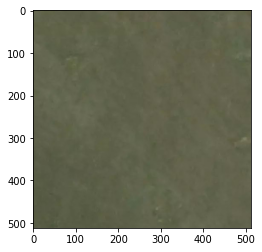

tensor(0)


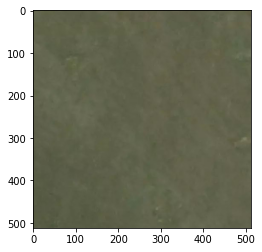

tensor(0)


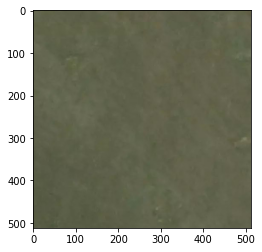

In [10]:
n = random.randint(0, len(valid_dataset))
for i in range(3):
    im, l = valid_dataset[n]
    print(l)
    plt.imshow(im.permute((1, 2, 0)).contiguous().numpy())
    plt.show()

In [11]:
# n = random.randint(0, len(test_dataset))
# for i in range(3):
#     im, l = test_dataset[n]
#     print(l)
#     plt.imshow(im.permute((1, 2, 0)).contiguous().numpy())
#     plt.show()

In [12]:
class NLL_OHEM(torch.nn.NLLLoss):                                                     
    """ Online hard example mining. """                                             
                                                                                   
    def __init__(self, ratio):      
        super(NLL_OHEM, self).__init__(None, True)                                 
        self.ratio = ratio                                                         
                                                                                   
    def forward(self, x, y, ratio=None):
        x = torch.nn.functional.log_softmax(x, dim=1)
        if ratio is not None:                                                      
            self.ratio = ratio                                                     
        num_inst = x.size(0)                                                       
        num_hns = int(self.ratio * num_inst)                                       
        x_ = x.clone()                                                           
        inst_losses = torch.autograd.Variable(torch.zeros(num_inst)).cuda()              
        for idx, label in enumerate(y.data):                                       
            inst_losses[idx] = -x_.data[idx, label]                                 
        #loss_incs = -x_.sum(1)                                                    
        _, idxs = inst_losses.topk(num_hns)                                        
        x_hn = x.index_select(0, idxs)                                             
        y_hn = y.index_select(0, idxs)                                             
        return torch.nn.functional.nll_loss(x_hn, y_hn)   

In [13]:
NUM_CLASSES = 2

CUDA = "cuda:0"
CPU = "cpu"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 12
NUM_LOADER_WORKERS = 8
EPOCH_COUNT = 35

BEST_PATH = './best.pth'
BEST_TL_PATH = './best.tl.pth'

NET = timm.create_model('repvgg_b2', num_classes=NUM_CLASSES, pretrained=True)
NET.to(DEVICE)
NET = NET.half()

CRITERION = NLL_OHEM(0.66)
OPTIMIZER = torch.optim.SGD(NET.parameters(), lr=1e-3)
# OPTIMIZER = torch.optim.Adam(NET.parameters(), lr=1e-4)
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER,
                                                       factor=0.1,
                                                       patience=5,
                                                       mode='max')

# Imagenet normalization
IMAGE_NORMALIZER = torch.nn.Sequential(
    torchvision.transforms.ConvertImageDtype(torch.half),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
)


TRAIN_LOADER = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=NUM_LOADER_WORKERS)
VALID_LOADER = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                           shuffle=False, num_workers=NUM_LOADER_WORKERS)
# TEST_LOADER = torch.utils.data.DataLoader(test_dataset, batch_size=1,
#                                            shuffle=False, num_workers=NUM_LOADER_WORKERS)

/home/user3/work/code/tgeo/venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [14]:
# timm.list_models(pretrained=True)

In [15]:
LOSS_PRINT_STEP = 1
HISTORY_LIST = []

def accuracy(x, y):
    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    correct = np.sum(x == y)
    total = y.shape[0]
    return correct / total

def f1(x, y):
    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return f1_score(y, x, average = 'macro')


EPOCH_KEY = 'EPOCH'
BATCH_KEY = 'BATCH'
LOSS_KEY = 'LOSS'
TRAIN_LOSS_KEY = 'TRAIN_LOSS'
LR_KEY = 'LR'
VAL_LOSS_KEY = 'VAL_LOSS'
VAL_ACC_KEY = 'VAL_ACC'
VAL_F1_KEY = 'VAL_F1'

best_score = 0.0
best_train_loss = float('inf')
for epoch in range(1, EPOCH_COUNT+1):  # loop over the dataset multiple times
    train_count = len(TRAIN_LOADER)
    NET.train()
    if epoch == 25: OPTIMIZER.param_groups[0]['lr'] = 3.333e-4
    with tqdm(TRAIN_LOADER, position=0) as train_data_iterator:
        total_train_loss = 0
        for batch_n, data in enumerate(train_data_iterator, 1):
            progress_update = False

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # zero the parameter gradients
            OPTIMIZER.zero_grad()

            # forward + backward + optimize
            outputs = NET(IMAGE_NORMALIZER(inputs))
            loss = CRITERION(outputs, labels)
            loss.backward()
            OPTIMIZER.step()
            
            loss_value = float(loss.item())
            total_train_loss += loss_value
            # print statistics
            history_item = {EPOCH_KEY: epoch,
                            BATCH_KEY: batch_n,
                            LOSS_KEY: loss_value}

            if batch_n == 1 or batch_n % LOSS_PRINT_STEP == 0:
                progress_update = True
            
            if batch_n == train_count:
                if VALID_LOADER is not None:
                    total_valid_loss = 0.0
                    NET.eval()
                    with torch.no_grad():
                        xs = torch.tensor([]).to(DEVICE).long()
                        ys = torch.tensor([]).to(DEVICE).long()
                        for valid_data in VALID_LOADER:
                            valid_indputs, valid_labels = valid_data
                            valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
                            valid_outputs = NET(IMAGE_NORMALIZER(valid_indputs))
                            total_valid_loss += CRITERION(valid_outputs, valid_labels)
                            
                            # print(valid_outputs.shape)
                            c = F.softmax(valid_outputs, dim=1)
                            c = torch.argmax(c, dim=1)
                            xs = torch.cat((xs, c.long()), dim=0)
                            ys = torch.cat((ys, valid_labels.long()), dim=0)
                    
                        avg_valid_loss = total_valid_loss / len(VALID_LOADER)
                        history_item[VAL_LOSS_KEY] = avg_valid_loss.item()
                        
                        acc_value = accuracy(xs, ys)
                        f1_value = f1(xs, ys)
                        history_item[VAL_ACC_KEY] = acc_value
                        history_item[VAL_F1_KEY] = f1_value
                        avg_train_loss = float(total_train_loss / len(TRAIN_LOADER))
                        history_item[TRAIN_LOSS_KEY] = avg_train_loss
                        history_item[LR_KEY] = OPTIMIZER.param_groups[0]['lr']
                        
                        HISTORY_LIST.append(history_item)
#                         SCHEDULER.step(acc_value)
                        if best_score < f1_value:
                            best_score = f1_value
                            torch.save(NET.state_dict(), BEST_PATH)
                            print('New best', best_score)
            
                        if best_train_loss > avg_train_loss:
                            best_train_loss = avg_train_loss
                            torch.save(NET.state_dict(), BEST_TL_PATH)
                            print('New best loss', avg_train_loss)

                    progress_update = True

            if progress_update:
                train_data_iterator.set_postfix(history_item)

print('\nTraining fininshed!')

 98%|███████████▋| 43/44 [00:33<00:00,  1.22it/s, EPOCH=1, BATCH=43, LOSS=0.544]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [00:39<00:00,  2.40s/it, EPOCH=1, BATCH=44, LOSS=0.462, VAL_LOSS=n

New best 0.5489224137931035
New best loss 0.5518132990056818


100%|█| 44/44 [00:39<00:00,  1.10it/s, EPOCH=1, BATCH=44, LOSS=0.462, VAL_LOSS=n
 98%|███████████▋| 43/44 [00:50<00:01,  1.28s/it, EPOCH=2, BATCH=43, LOSS=0.259]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)


New best 0.6793741109530583


100%|█| 44/44 [00:59<00:00,  1.34s/it, EPOCH=2, BATCH=44, LOSS=0.453, VAL_LOSS=n


New best loss 0.45799671519886365


 98%|███████████▋| 43/44 [01:15<00:01,  1.67s/it, EPOCH=3, BATCH=43, LOSS=0.519]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)


New best 0.7228413518166168


100%|█| 44/44 [01:26<00:00,  1.97s/it, EPOCH=3, BATCH=44, LOSS=0.292, VAL_LOSS=n


New best loss 0.4494545676491477


 98%|███████████▋| 43/44 [01:33<00:02,  2.00s/it, EPOCH=4, BATCH=43, LOSS=0.413]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [01:45<00:00,  2.39s/it, EPOCH=4, BATCH=44, LOSS=0.224, VAL_LOSS=n
 98%|███████████▋| 43/44 [01:42<00:02,  2.03s/it, EPOCH=5, BATCH=43, LOSS=0.583]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [01:55<00:00,  2.62s/it, EPOCH=5, BATCH=44, LOSS=0.269, VAL_LOSS=n


New best loss 0.41868175159801135


 98%|███████████▋| 43/44 [01:53<00:02,  2.27s/it, EPOCH=6, BATCH=43, LOSS=0.915]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:06<00:00,  2.88s/it, EPOCH=6, BATCH=44, LOSS=0.297, VAL_LOSS=n


New best 0.7706552706552707


 98%|███████████▋| 43/44 [02:03<00:02,  2.67s/it, EPOCH=7, BATCH=43, LOSS=0.724]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:17<00:00,  3.13s/it, EPOCH=7, BATCH=44, LOSS=0.346, VAL_LOSS=n


New best loss 0.3970614346590909


 98%|███████████▋| 43/44 [02:07<00:02,  2.35s/it, EPOCH=8, BATCH=43, LOSS=0.441]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:25<00:00,  3.30s/it, EPOCH=8, BATCH=44, LOSS=0.415, VAL_LOSS=n
 98%|█████████████▋| 43/44 [02:12<00:02,  2.86s/it, EPOCH=9, BATCH=43, LOSS=0.4]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:27<00:00,  3.36s/it, EPOCH=9, BATCH=44, LOSS=0.711, VAL_LOSS=n


New best loss 0.3536737615411932


 98%|██████████▊| 43/44 [02:13<00:02,  2.50s/it, EPOCH=10, BATCH=43, LOSS=0.425]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:29<00:00,  3.39s/it, EPOCH=10, BATCH=44, LOSS=0.124, VAL_LOSS=


New best 0.7804251905334938


 98%|██████████▊| 43/44 [02:16<00:02,  2.90s/it, EPOCH=11, BATCH=43, LOSS=0.166]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:33<00:00,  3.48s/it, EPOCH=11, BATCH=44, LOSS=0.48, VAL_LOSS=n


New best loss 0.3271886652166193


 98%|██████████▊| 43/44 [02:19<00:03,  3.03s/it, EPOCH=12, BATCH=43, LOSS=0.361]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)


New best 0.8062575210589651


100%|█| 44/44 [02:35<00:00,  3.54s/it, EPOCH=12, BATCH=44, LOSS=0.214, VAL_LOSS=


New best loss 0.2954989346590909


 98%|██████████▊| 43/44 [02:18<00:02,  3.00s/it, EPOCH=13, BATCH=43, LOSS=0.199]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)


New best 0.8485637797554446


100%|█| 44/44 [02:38<00:00,  3.60s/it, EPOCH=13, BATCH=44, LOSS=0.362, VAL_LOSS=


New best loss 0.2832794189453125


 98%|██████████▊| 43/44 [02:25<00:03,  3.38s/it, EPOCH=14, BATCH=43, LOSS=0.579]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:42<00:00,  3.69s/it, EPOCH=14, BATCH=44, LOSS=0.131, VAL_LOSS=
 98%|██████████▊| 43/44 [02:40<00:03,  3.23s/it, EPOCH=15, BATCH=43, LOSS=0.225]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:59<00:00,  4.07s/it, EPOCH=15, BATCH=44, LOSS=0.358, VAL_LOSS=


New best 0.8676085818942962


 98%|██████████▊| 43/44 [02:30<00:03,  3.11s/it, EPOCH=16, BATCH=43, LOSS=0.411]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:50<00:00,  3.87s/it, EPOCH=16, BATCH=44, LOSS=0.291, VAL_LOSS=


New best loss 0.2783452814275568


 98%|██████████▊| 43/44 [02:25<00:03,  3.22s/it, EPOCH=17, BATCH=43, LOSS=0.448]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:41<00:00,  3.67s/it, EPOCH=17, BATCH=44, LOSS=0.25, VAL_LOSS=n


New best 0.8816176470588235


 98%|██████████▊| 43/44 [02:36<00:02,  2.80s/it, EPOCH=18, BATCH=43, LOSS=0.112]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:55<00:00,  3.99s/it, EPOCH=18, BATCH=44, LOSS=0.0379, VAL_LOSS


New best loss 0.21860573508522727


 98%|██████████▊| 43/44 [02:35<00:03,  3.85s/it, EPOCH=19, BATCH=43, LOSS=0.148]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:56<00:00,  4.01s/it, EPOCH=19, BATCH=44, LOSS=0.104, VAL_LOSS=
 98%|█████████▊| 43/44 [02:25<00:03,  3.00s/it, EPOCH=20, BATCH=43, LOSS=0.0731]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:43<00:00,  3.72s/it, EPOCH=20, BATCH=44, LOSS=0.049, VAL_LOSS=


New best 0.8983657150873254


 98%|██████████▊| 43/44 [02:21<00:03,  3.10s/it, EPOCH=21, BATCH=43, LOSS=0.446]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:38<00:00,  3.60s/it, EPOCH=21, BATCH=44, LOSS=0.342, VAL_LOSS=
 98%|█████████▊| 43/44 [02:33<00:03,  3.05s/it, EPOCH=22, BATCH=43, LOSS=0.0892]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:52<00:00,  3.93s/it, EPOCH=22, BATCH=44, LOSS=0.206, VAL_LOSS=
 98%|██████████▊| 

New best 0.9082621082621083


 98%|█████████▊| 43/44 [02:28<00:03,  3.76s/it, EPOCH=26, BATCH=43, LOSS=0.0892]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:52<00:00,  3.93s/it, EPOCH=26, BATCH=44, LOSS=0.434, VAL_LOSS=


New best 0.9110005527915976


 98%|█████████▊| 43/44 [02:38<00:03,  3.41s/it, EPOCH=27, BATCH=43, LOSS=0.0651]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:57<00:00,  4.03s/it, EPOCH=27, BATCH=44, LOSS=0.219, VAL_LOSS=
 98%|██████████▊| 43/44 [02:34<00:03,  3.27s/it, EPOCH=28, BATCH=43, LOSS=0.626]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:54<00:00,  3.97s/it, EPOCH=28, BATCH=44, LOSS=0.0696, VAL_LOSS


New best loss 0.20367882468483664


 98%|██████████▊| 43/44 [02:39<00:03,  3.14s/it, EPOCH=29, BATCH=43, LOSS=0.064]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [03:01<00:00,  4.12s/it, EPOCH=29, BATCH=44, LOSS=0.0322, VAL_LOSS


New best loss 0.19267966530539773


 98%|███████████▋| 43/44 [02:41<00:03,  3.94s/it, EPOCH=30, BATCH=43, LOSS=0.13]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [03:06<00:00,  4.23s/it, EPOCH=30, BATCH=44, LOSS=0.155, VAL_LOSS=


New best loss 0.18029854514382102


 98%|█████████▊| 43/44 [02:52<00:04,  4.05s/it, EPOCH=31, BATCH=43, LOSS=0.0347]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [03:14<00:00,  4.42s/it, EPOCH=31, BATCH=44, LOSS=0.144, VAL_LOSS=


New best 0.9232550221314266


 98%|██████████▊| 43/44 [02:29<00:03,  3.22s/it, EPOCH=32, BATCH=43, LOSS=0.391]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:52<00:00,  3.92s/it, EPOCH=32, BATCH=44, LOSS=0.119, VAL_LOSS=
 98%|█████████▊| 43/44 [02:30<00:03,  3.46s/it, EPOCH=33, BATCH=43, LOSS=0.0381]/tmp/ipykernel_12850/178319240.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_indputs, valid_labels = valid_indputs.to(DEVICE), torch.tensor(valid_labels).to(DEVICE)
100%|█| 44/44 [02:46<00:00,  3.79s/it, EPOCH=33, BATCH=44, LOSS=0.305, VAL_LOSS=
 98%|███████████▋|


Training fininshed!


In [16]:
train_log = pd.DataFrame(HISTORY_LIST)
display(train_log)

,EPOCH,BATCH,LOSS,VAL_LOSS,VAL_ACC,VAL_F1,TRAIN_LOSS,LR
0,1,44,0.462402,NaN,0.838509,0.548922,0.551813,0.001000
1,2,44,0.452881,NaN,0.869565,0.679374,0.457997,0.001000
2,3,44,0.291504,NaN,0.881988,0.722841,0.449455,0.001000
3,4,44,0.223755,NaN,0.881988,0.722841,0.470609,0.001000
4,5,44,0.269287,NaN,0.857143,0.713501,0.418682,0.001000
5,6,44,0.297119,NaN,0.875776,0.770655,0.427895,0.001000
6,7,44,0.346436,NaN,0.888199,0.753571,0.397061,0.001000
7,8,44,0.414795,NaN,0.894410,0.762434,0.427035,0.001000
8,9,44,0.710938,NaN,0.894410,0.762434,0.353674,0.001000
9,10,44,0.124451,NaN,0.894410,0.780425,0.384029,0.001000


<AxesSubplot:xlabel='EPOCH'>

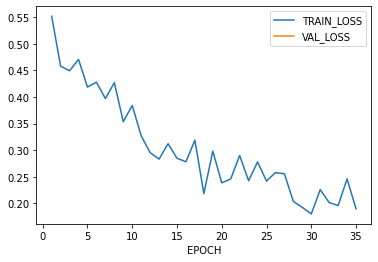

In [17]:
train_log.plot(x="EPOCH", y=["TRAIN_LOSS", "VAL_LOSS"])

<AxesSubplot:xlabel='EPOCH'>

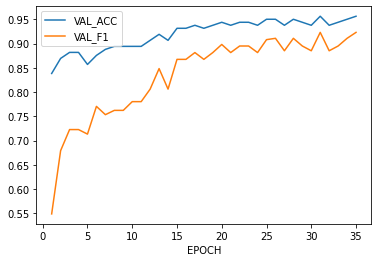

In [18]:
train_log.plot(x="EPOCH", y=["VAL_ACC", "VAL_F1"])